# intro

The purpose of this notebook create the J terms for a single map grid cell at the surface, show the residuals and look at the comparable contributions of different terms

# packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# read grid and files

In [4]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

## Get the timesteps

In [5]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2014"] = np.arange(6,8,1)
# times["2014"] = np.arange(9,11,1)
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

In [6]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

In [7]:
# ocean and ice
AB_gT=0
AB_gS=0

# load the terms for TFLUX

In [8]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
THETA = THETADR.reshape((nz,ny,nx)) / DRF3d


# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

SALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SALT = SALTDR.reshape((nz,ny,nx)) / DRF3d

In [9]:
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))

In [10]:
# this cell will be used to add the diagnostics we need
file_name = "exf_zflux_set1"
meta_exf_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_exf_zflux_set1["fldList"])
varnames = np.array(["EXFpreci", "EXFevap", "EXFroff", "EXFempmr" ])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
EXFpreci,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
EXFevap,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
EXFroff,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
EXFempmr,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

EXFpreci = EXFpreci.reshape(ny,nx)                                    # m/s
EXFevap =  EXFevap.reshape(ny,nx)
EXFroff =  EXFroff.reshape(ny,nx)
EXFempmr =  EXFempmr.reshape(ny,nx)

In [11]:
# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)

In [12]:
# rewrite with only reading in these lines, be sure to compare
meta_budg2d_zflux_set1= parsemeta(dirIn + "budg2d_zflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_zflux_set1['fldList'])
varnames = np.array(['oceFWflx','SIatmFW',"SFLUX","oceSPflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
oceFWflxt2,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[0])
SFLUX,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[2])      # W/m^2
oceSPflx,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[3])      # W/m^2

oceFWflxt2 = oceFWflxt2.reshape(ny,nx)                     # kg/m^2/s
SFLUX = SFLUX.reshape(ny,nx)
oceSPflx = oceSPflx.reshape(ny,nx)

In [13]:
# rewrite with only reading in these lines, be sure to compare
meta_budg2d_zflux_set1= parsemeta(dirIn + "budg2d_zflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_zflux_set1['fldList'])
varnames = np.array(['oceFWflx','SIatmFW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
oceFWflxt1,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[0]),returnmeta=True,rec = recs[0])

oceFWflxt1 = oceFWflxt1.reshape(ny,nx)                     # kg/m^2/s

# do the breakdown for TFLUX

In [14]:
# TERMS TO DOUBLE CHECK THE DEFINITION OF from diags_oceanic_surf_flux.F
# Qsw = oceQsw     # J/m^2/s
# EmPmR = oceFWflx (kg/m^2/s) 
# PmEpR = -EmPmR = -oceFWflx (kg/m^2/s) * J/kg.degC * degC = J/m^2/s

# surfaceForcingT  - defined in external_forcing_surf
# HeatCapacity_Cp
# adjustColdSST_diag
# rUnit2mass
Qsw = oceQsw          # W/m^2 = J/s/m^2 * degC.kg/J = degC
EmPmR = oceFWflxt2    # kg/m^2/s    # manually do the staggering of the timesteps
PmEpR = -oceFWflxt1   # kg/m^2/s    * Cp * theta = W/m^2
Qnet = oceQnet        # W/m^2

In [15]:
Cp = 3994          # J/kg.degC
recip_Cp = 1/Cp    # kg.degC/J

# from external_forcing_surf.F
Qnet = oceQnet # W/m^2
Qsw = oceQsw # W/m^2

surfaceForcingT = (-oceQnet - Qsw) * recip_Cp  # J/m^2/s * kg.degC/J = kg.degC/m^2/s
surfaceForcingT = surfaceForcingT #+ (PmEpR *THETA[0])          # kg.degC/m^2/s
tmp1k = -Qsw + (surfaceForcingT * Cp) # W/m^2
tmp1k = tmp1k + (PmEpR * THETA[0] * Cp)   # W/m^2

testtmp = -oceQnet + (-EmPmR * THETA[0] * Cp)

In [16]:
# saltFlux = oceSflux  # check g/m^2/s

(400.0, 600.0)

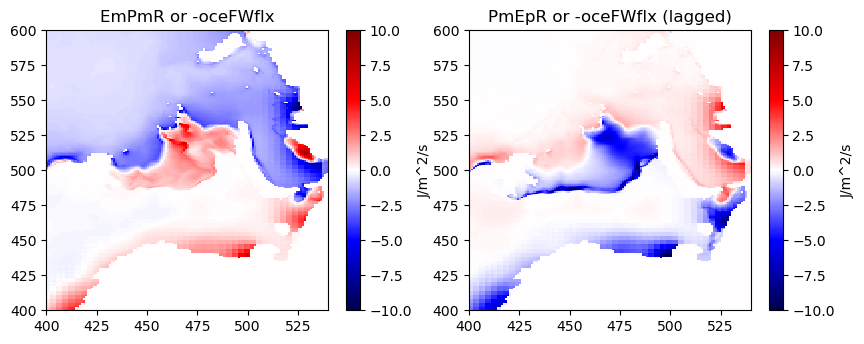

In [17]:
# compare the two time steps for empmr from the oceFWflx
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
a = -Qsw                        # J/m^2/s
cb = ax.pcolormesh(get_aste_tracer(EmPmR * THETA[0] *Cp,nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("EmPmR or -oceFWflx")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(222)
b = -Qsw + surfaceForcingT     # J/m^2/s
cb = ax.pcolormesh(get_aste_tracer(PmEpR * THETA[0] *Cp,nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("PmEpR or -oceFWflx (lagged)")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

(400.0, 600.0)

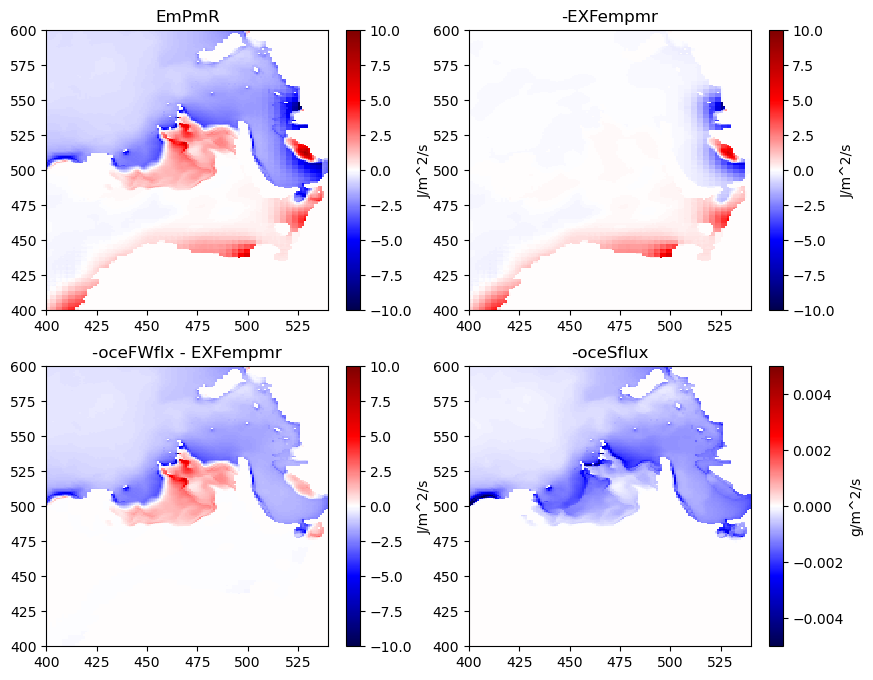

In [18]:
# compare the EXF empmr ot the written one

# compare the two time steps for empmr from the oceFWflx
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
a = EmPmR * THETA[0] *Cp
cb = ax.pcolormesh(get_aste_tracer(EmPmR * THETA[0] *Cp,nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("EmPmR")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(222)
b = -EXFempmr * myparms['rhoconst'] * Cp * THETA[0]
cb = ax.pcolormesh(get_aste_tracer(-EXFempmr * myparms['rhoconst'] * Cp * THETA[0],nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("-EXFempmr")
ax.set_xlim(400,540)
ax.set_ylim(400,600)


# this leftover is from the ice
ax = plt.subplot(223)
cb = ax.pcolormesh(get_aste_tracer(a-b,nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("-oceFWflx - EXFempmr")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(224)
cb = ax.pcolormesh(get_aste_tracer(-oceSflux,nfx,nfy)[0],cmap='seismic',vmin=-.005,vmax=.005)
plt.colorbar(cb,label="g/m^2/s")
ax.set_title("-oceSflux")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

(400.0, 600.0)

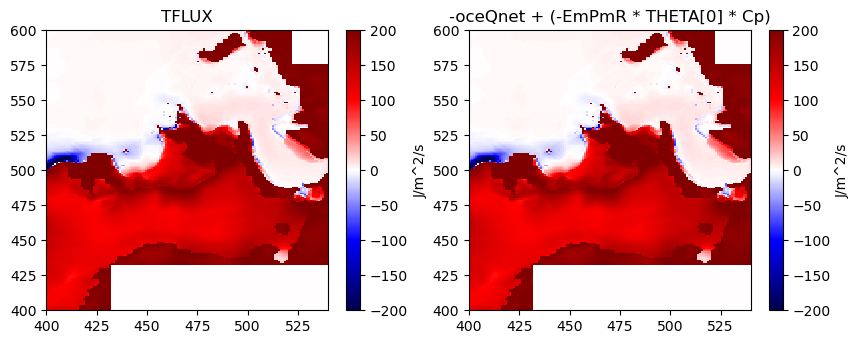

In [19]:
# compare oceFWflx to EXF terms
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
a = TFLUX
cb = ax.pcolormesh(get_aste_tracer(TFLUX,nfx,nfy)[0],cmap='seismic',vmin=-200,vmax=200)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("TFLUX")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(222)
b = -testtmp
cb = ax.pcolormesh(get_aste_tracer(-testtmp,nfx,nfy)[0],cmap='seismic',vmin=-200,vmax=200)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("-oceQnet + (-EmPmR * THETA[0] * Cp)")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

# ax = plt.subplot(223)
# cb = ax.pcolormesh(get_aste_tracer(a-b,nfx,nfy)[0],cmap='seismic',vmin=-.1,vmax=.1)
# plt.colorbar(cb,label="J/m^2/s")
# ax.set_title("tmp1k")
# ax.set_xlim(400,540)
# ax.set_ylim(400,600)

(400.0, 600.0)

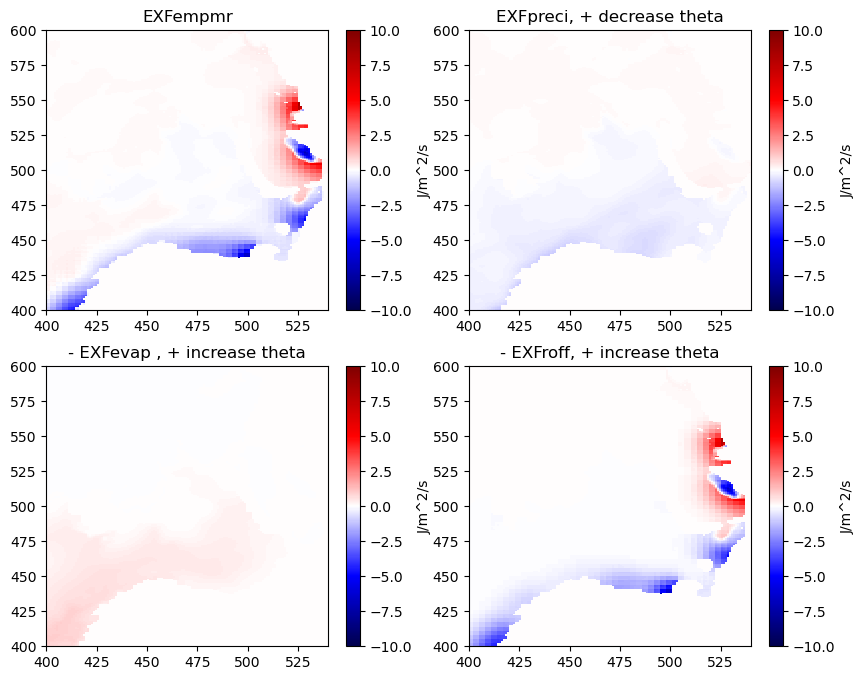

In [20]:
# do a plot of the EXF terms

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
cb = ax.pcolormesh(get_aste_tracer(EXFempmr * myparms['rhoconst'] * Cp * THETA[0],nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("EXFempmr")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(222)
cb = ax.pcolormesh(get_aste_tracer(-EXFpreci* myparms['rhoconst'] * Cp * THETA[0] ,nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("EXFpreci, + decrease theta")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(223)
cb = ax.pcolormesh(get_aste_tracer(EXFevap * myparms['rhoconst'] * Cp * THETA[0],nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("- EXFevap , + increase theta")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(224)
cb = ax.pcolormesh(get_aste_tracer(-EXFroff * myparms['rhoconst'] * Cp * THETA[0],nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
plt.colorbar(cb,label="J/m^2/s")
ax.set_title("- EXFroff, + increase theta")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

In [21]:
# fig = plt.figure(figsize=(12,8))
# ax = plt.subplot(231)
# # m/s * J/kg.degC * degC * kg/m^3
# a = (oceQnet - oceQsw) + (EXFempmr * myparms['rhoconst']* theta[0] * Cp) + oceQsw    
# cb = ax.pcolormesh(get_aste_tracer(a,nfx,nfy)[0],cmap='seismic',vmin=-200,vmax=200)
# plt.colorbar(cb,label="J/m^2/s")
# ax.set_title("oceSflux*Cp * theta[0] / salt[0] , + increase theta")
# ax.set_xlim(400,540)
# ax.set_ylim(400,600)

# ax = plt.subplot(232)
# cb = ax.pcolormesh(get_aste_tracer(TFLUX - a,nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
# plt.colorbar(cb,label="J/m^2/s")
# ax.set_title("TFLUX - TFLUXcalc , + increase theta")
# ax.set_xlim(400,540)
# ax.set_ylim(400,600)

# ax = plt.subplot(233)
# cb = ax.pcolormesh(get_aste_tracer(TFLUX - b,nfx,nfy)[0],cmap='seismic',vmin=-100,vmax=100)
# plt.colorbar(cb,label="J/m^2/s")
# # ax.set_title("oceSflux*Cp * theta[0] / salt[0] , + increase theta")
# ax.set_xlim(400,540)
# ax.set_ylim(400,600)

# ax = plt.subplot(234)
# # g/m^2/s * J/kg.degC * degC / PSU = J/m^2/s
# cb = ax.pcolormesh(get_aste_tracer(6*oceSflux*Cp * theta[0] / salt[0],nfx,nfy)[0],cmap='seismic',vmin=-10,vmax=10)
# plt.colorbar(cb,label="J/m^2/s")
# ax.set_title("oceSflux*Cp * theta[0] / salt[0] , + increase theta")
# ax.set_xlim(400,540)
# ax.set_ylim(400,600)

# do for SFLUX

In [22]:
# external_forc_surf.F

# surfaceForcingS = -saltFlux

In [23]:
# reload the salinity variables because we modified these earlier
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX",'oceFWflx','SIatmFW'])   # add in other terms to look at balance
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])   # g/m^2/s
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])      # g/m^2/s
oceFWflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])   # kg/m^2/s
SIatmFW,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])    # kg/m^2/s

oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)
oceFWflx = oceFWflx.reshape(ny,nx)
SIatmFW = SIatmFW.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)

(400.0, 600.0)

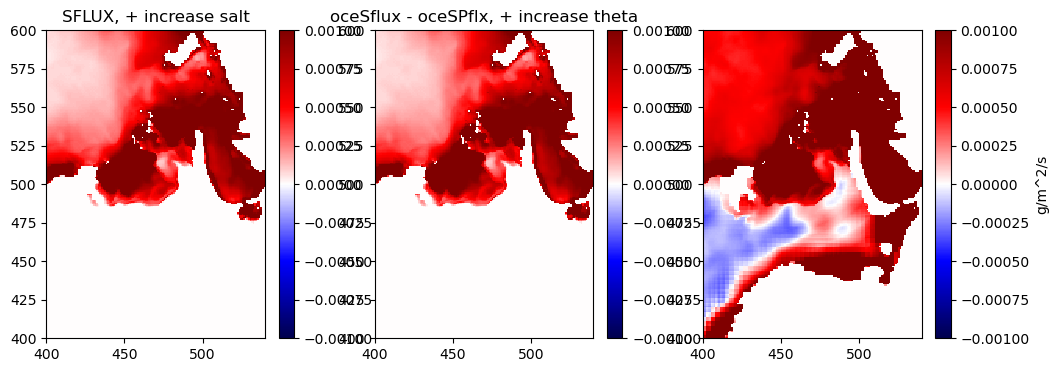

In [24]:
fig = plt.figure(figsize=(12,4))
ax = plt.subplot(131)
cb = ax.pcolormesh(get_aste_tracer(SFLUX,nfx,nfy)[0],cmap='seismic',vmin=-.001,vmax=.001)
plt.colorbar(cb,label="g/m^2/s")
ax.set_title("SFLUX, + increase salt")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(132)
cb = ax.pcolormesh(get_aste_tracer(oceSflux - oceSPflx,nfx,nfy)[0],cmap='seismic',vmin=-.001,vmax=.001)
plt.colorbar(cb,label="g/m^2/s")
ax.set_title("oceSflux - oceSPflx")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(133)
surForcS = oceSflux - (EXFempmr*myparms['rhoconst']*SALT[0])  # m/s * kg/m^3 * PSU = kg/m^2/s * PSU = g/m^2/s
cb = ax.pcolormesh(get_aste_tracer(surForcS,nfx,nfy)[0],cmap='seismic',vmin=-.001,vmax=.001)
plt.colorbar(cb,label="g/m^2/s")
# ax.set_title("oceSflux*Cp * theta[0] / salt[0] , + increase theta")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

# Now try and create the J terms for one cell

In [91]:
# read oceSPdep  - -- depth where the salt penetrates
file_name = "state_2d_set1"
meta_state_2d_set1 = parsemeta(dirState + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_state_2d_set1["fldList"])
varnames = np.array(["oceSPDep", "SIarea" ])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPDep,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SIarea,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])
oceSPDep = oceSPDep.reshape(ny,nx)
SIarea =  SIarea.reshape(ny,nx)
print(oceSPDep[y,x])  # this is the depth to which salt penetrates at this point

18.105384826660156
